In [2]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from astropy.time import Time

matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

# Define Functions

In [3]:
def retrieve_efd_client(is_at_summit=True):
    """
    Retrieves a client to the Engireering Facility Database. 
    
    Parameters
    ----------
    is_at_summit : bool, optional
        If this notebook runs at the Summit, returns a client that connect to 
        the Summit EFD. Otherwhice, results the NCSA TestSand (NST) EFD.
    
    Returns
    -------
    EfdClient : the interface object between Nublado and the Summit or NST EFD.
    """
    from lsst_efd_client import EfdClient
    
    c = EfdClient('summit_efd') if is_at_summit \
        else EfdClient('ncsa_teststand_efd') 
        
    return c

async def retrieve_rotator_angle_and_torques_from_efd(client, start, end):
    """
    Retrieves the Rotator Angle and the Motors torques from the EFD.
    
    Parameters
    ----------
    client : EfdClient
        Interface that allows querying data from the EFD.
    start : datetime string
        ISOT Time in UTC associated to the start of the data.
    end : datetime string
        ISOT Time in UTC associated to the end of the data.
        
    Returns
    -------
    _df : DataFrame
        Table containing the queried data.
    """
    _df_rotator = await client.select_time_series(
        'lsst.sal.MTRotator.rotation', 
        fields='actualPosition', 
        start=start, 
        end=end)

    _df_motor1 = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields='torque0', 
        start=start, 
        end=end)

    _df_motor2 = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields='torque1', 
        start=start, 
        end=end)

    _df = pd.merge(_df_rotator, _df_motor1, left_index=True, right_index=True)
    _df = pd.merge(_df, _df_motor2, left_index=True, right_index=True)
    _df = _df.dropna()
    
    return _df

# Get sal object Script messages from each test

In [4]:
# I would like to skip this. Learn to do a better EFD query and just juse the ScriptID

t_start = Time('2022-03-01T15:40:22.143140', scale='utc', format='isot') 
t_end = Time('2022-03-01T18:52:17.886160', scale='utc', format='isot')

In [5]:
summit = 1 #use this for summit testing
efd_client = retrieve_efd_client(summit)

In [6]:
# Get the script messages

messages = await efd_client.select_time_series(
        "lsst.sal.Script.logevent_logMessage", 
        fields=['ScriptID','message'], 
        start=t_start, 
        end=t_end)
messages.reset_index(inplace=True)

In [7]:
messages

,index,ScriptID,message
0,2022-03-01 15:40:22.143000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder L...
1,2022-03-01 15:40:31.330000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder L...
2,2022-03-01 16:16:43.756000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder L...
3,2022-03-01 16:26:45.725000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder L...
4,2022-03-01 16:34:00.933000+00:00,42658886,END -- LVV-2261: Hexapod at 0 - Pathfinder Lin...
5,2022-03-01 16:46:05.840000+00:00,42658886,START -- LVV-2261: Hexapod u=-0.36deg - Pathfi...
6,2022-03-01 17:11:13.165000+00:00,42658886,START -- LVV-2261: Hexapod u=-0.36deg - Pathfi...
7,2022-03-01 17:26:29.561000+00:00,42658886,END -- LVV-2261: Hexapod u=-0.36deg - Pathfind...
8,2022-03-01 17:28:43.191000+00:00,42658886,START -- LVV-2261: Hexapod u=-0.36deg v=-0.36d...
9,2022-03-01 17:31:42.666000+00:00,42658886,START -- LVV-2261: Hexapod u=-0.18deg v=-0.18d...


# Make a dataframe for the rotator data for each test.

In [8]:
# Examine the good tests by hand. Find the START/END pairs with no errors in between them.
# Make a dataframe for each.

runs = [3, 6, 10, 16, 22, 26]
dfs = []

for i in runs:
    
    print(f'Test #{i} - {messages.message[i]}')
    start_time = Time(messages['index'][i])
    stop_time = Time(messages['index'][i+1])

    df = await retrieve_rotator_angle_and_torques_from_efd(efd_client, start_time, stop_time)
    new = df.assign(test = i) \
            .assign(net_torque = lambda x: 1.0e6*(x.torque0 + x.torque1))
    new.reset_index(inplace=True)
    # display(new)    
    dfs.append(new)
 

Test #3 - START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 16:26:45.725091 UTC
Test #6 - START -- LVV-2261: Hexapod u=-0.36deg - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 17:11:13.165259 UTC
Test #10 - START -- LVV-2261: Hexapod u=-0.18deg v=-0.18deg - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 17:31:42.666555 UTC
Test #16 - START -- LVV-2261: Hexapod u=-0.25deg v=-0.25deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 17:45:20.661638 UTC
Test #22 - START -- LVV-2261: Hexapod u=+0.253deg v=-0.253deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 18:18:45.484806 UTC
Test #26 - START -- LVV-2261: Hexapod u=+0deg v=-0.36deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 18:43:42.398629 UTC


In [9]:
print(f'Test #{runs[0]} - {messages.message[runs[0]]}')
display(dfs[0])

Test #3 - START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 16:26:45.725091 UTC


,index,actualPosition,torque0,torque1,test,net_torque
0,2022-03-01 16:26:45.726000+00:00,0.000281,-0.000145,0.000189,3,44.0
1,2022-03-01 16:26:45.776000+00:00,0.000215,-0.000130,0.000205,3,75.0
2,2022-03-01 16:26:45.826000+00:00,0.000108,-0.000117,0.000216,3,99.0
3,2022-03-01 16:26:45.876000+00:00,-0.000051,-0.000109,0.000224,3,115.0
4,2022-03-01 16:26:45.926000+00:00,-0.000177,-0.000104,0.000230,3,126.0
...,...,...,...,...,...,...
7073,2022-03-01 16:34:00.116000+00:00,-0.000328,-0.000185,0.000147,3,-38.0
7074,2022-03-01 16:34:00.216000+00:00,-0.000274,-0.000222,0.000111,3,-111.0
7075,2022-03-01 16:34:00.316000+00:00,-0.000022,-0.000248,0.000088,3,-160.0
7076,2022-03-01 16:34:00.367000+00:00,0.000127,-0.000254,0.000075,3,-179.0


# Make Plots

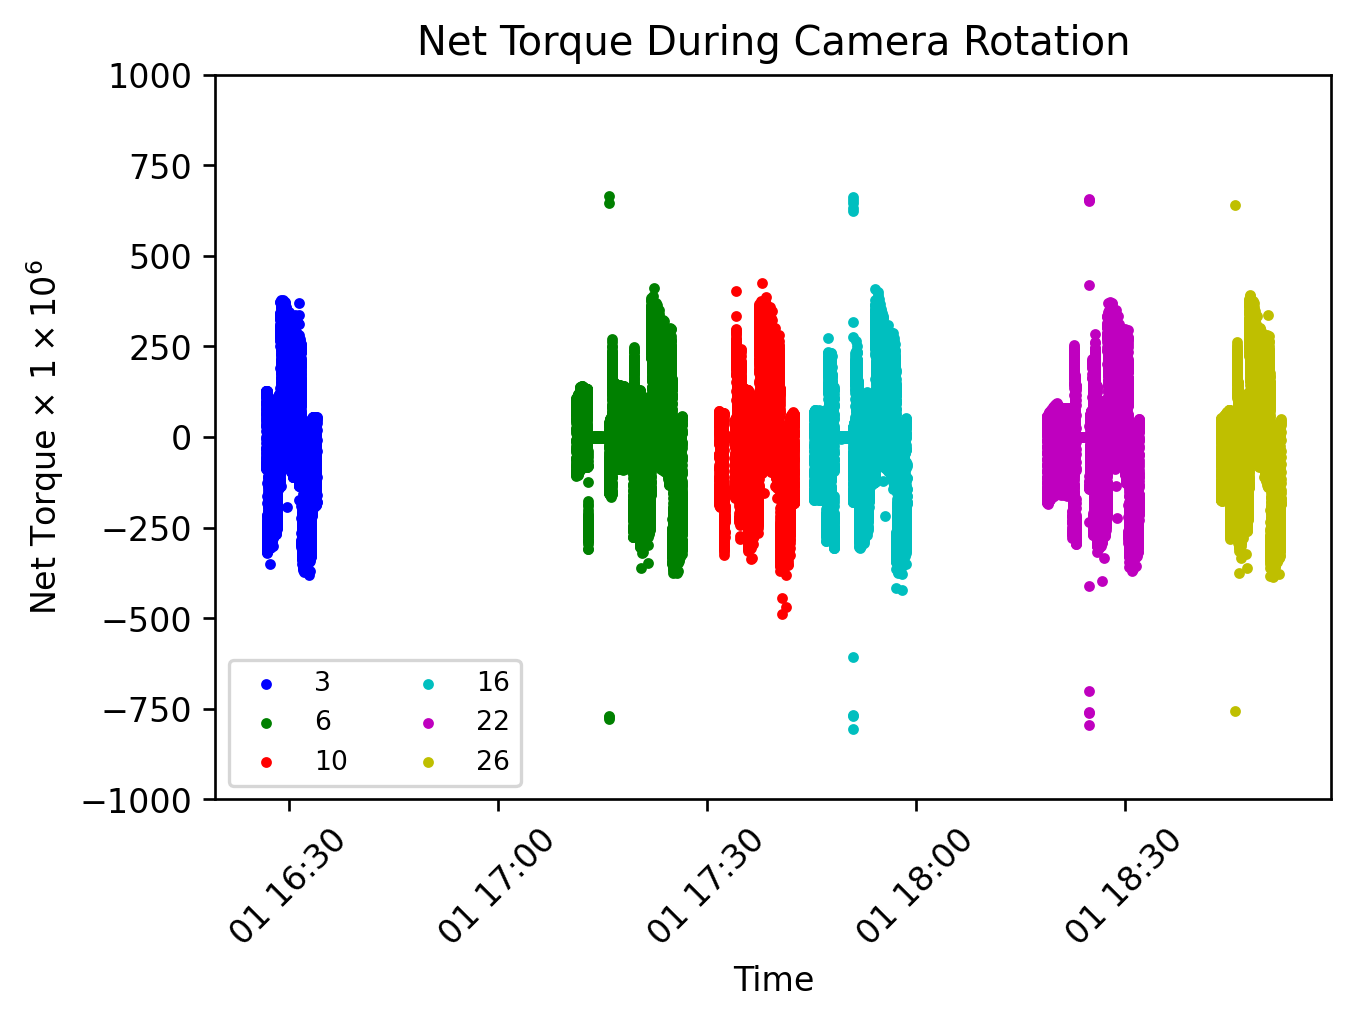

In [21]:
ax1 = dfs[0].plot.scatter('index', 'net_torque', marker=".", color='b', s=20.0, label=f'{runs[0]}')
ax2 = dfs[1].plot.scatter('index', 'net_torque', marker=".", color='g', s=20.0, ax=ax1, label=f'{runs[1]}')
ax3 = dfs[2].plot.scatter('index', 'net_torque', marker=".", color='r', s=20.0, ax=ax1, label=f'{runs[2]}')
ax4 = dfs[3].plot.scatter('index', 'net_torque', marker=".", color='c', s=20.0, ax=ax1, label=f'{runs[3]}')
ax5 = dfs[4].plot.scatter('index', 'net_torque', marker=".", color='m', s=20.0, ax=ax1, label=f'{runs[4]}')
ax6 = dfs[5].plot.scatter('index', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{runs[5]}')

#dfs[5].plot.scatter('index', 'net_torque', marker=".", color='blue', s=.01)

plt.title(r'Net Torque During Camera Rotation')

#plt.ylim(-.001, .001)
plt.ylim(-1000, 1000)
plt.xticks(rotation=45)
plt.xlabel(r'Time')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');
plt.legend(ncol=2, loc='lower left', fontsize=8)


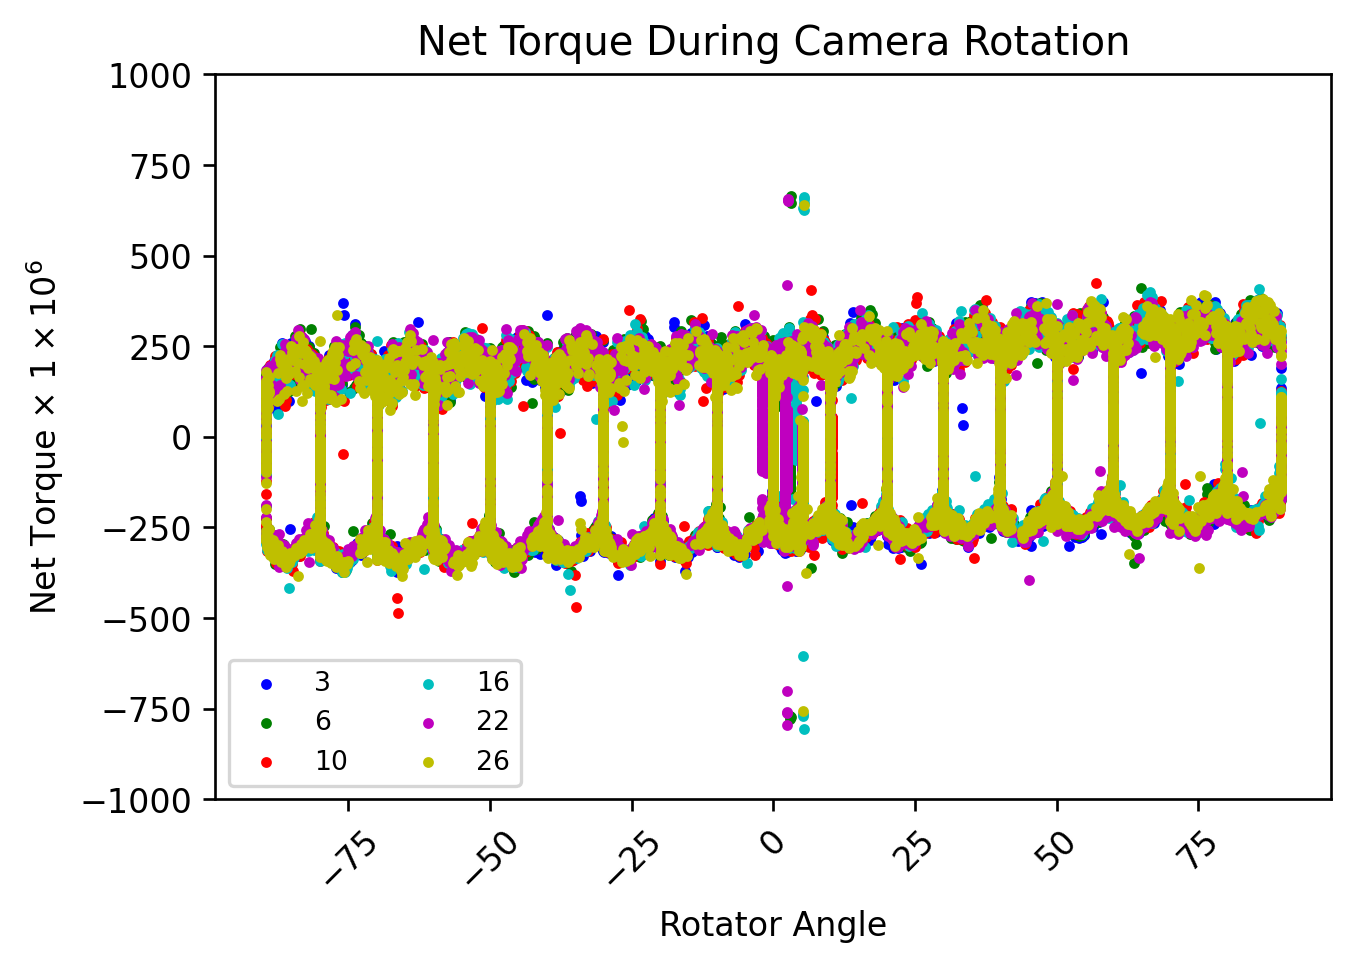

In [24]:
#dfs[0].plot.scatter('actualPosition', 'net_torque', marker=".", s=.1)

ax1 = dfs[0].plot.scatter('actualPosition', 'net_torque', marker=".", color='b', s=20.0, label=f'{runs[0]}')
ax2 = dfs[1].plot.scatter('actualPosition', 'net_torque', marker=".", color='g', s=20.0, ax=ax1, label=f'{runs[1]}')
ax3 = dfs[2].plot.scatter('actualPosition', 'net_torque', marker=".", color='r', s=20.0, ax=ax1, label=f'{runs[2]}')
ax4 = dfs[3].plot.scatter('actualPosition', 'net_torque', marker=".", color='c', s=20.0, ax=ax1, label=f'{runs[3]}')
ax5 = dfs[4].plot.scatter('actualPosition', 'net_torque', marker=".", color='m', s=20.0, ax=ax1, label=f'{runs[4]}')
ax6 = dfs[5].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{runs[5]}')


plt.title(r'Net Torque During Camera Rotation')
#plt.ylim(-.001, .001)
plt.ylim(-1000, 1000)

plt.xticks(rotation=45)
plt.xlabel(r'Rotator Angle')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');

plt.legend(ncol=2, loc='lower left', fontsize=8)